In [4]:
# CRNN (Convolutional Recurrent Neural Network) Untuk Memprediksi Tulisan Tangan

#Convolutional akan digunakan untuk **memproses gambar**, **proses ini dilakukan secara recurrent**

import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [5]:
# Loading data untuk training menggunakan train & valid set + melihat data yang akan di-train
train = pd.read_csv('data/written_name_train.csv')
test = pd.read_csv('data/written_name_test.csv')

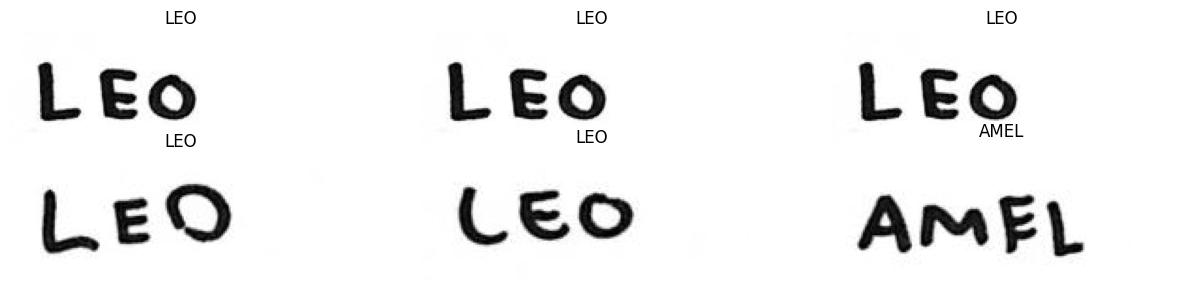

In [6]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'data/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [9]:
### Melihat data kosong
print("Data kosong di train set: ", train['IDENTITY'].isnull().sum())
print("Data kosong di test set: ", test['IDENTITY'].isnull().sum())

Data kosong di train set:  0
Data kosong di test set:  0


In [10]:
## Preprocessing gambar untuk training

# * 1. **Gambar dijadikan grayscale**, kemudian diubah sizenya menjadi **256 (width) dan 64 (height)**.  
# * 2. Gambar akan di-crop jika melebihi 256 dan 64 pixel. Jika gambar kurang dari 256 dan 64 pixel, gambar akan di-padding dengan pixel putih.
# * 3. Gambar dirotasi 90 derajat ke kanan untuk memudahkan proses modelling
# * 4. Matriks gambar **dinormalisasi ke range [0,1]** dari yang sebelumnya memiliki value [0, 255]

def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [11]:
# Model akan **di-train pada 50 gambar dan ditest pada 20 gambar**.
train_size = 50
test_size= 20

In [12]:
train_x = []

for i in range(train_size):
    img_dir = 'data/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [13]:
test_x = []

for i in range(test_size):
    img_dir = 'data/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [14]:
#Agar sesuai dengan format CNN, dilakukan reshape menggunakan numpy menjadi 4 dimensi
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

In [16]:
# Mempersiapkan label untuk Connectionist Temporal Classification (CTC) loss

# Untuk menggunakan CTC, label harus dikonversi menjadi angka yang merepresentasikan setiap karakter pada training set (karakter alphabet, -, ', dan " ").

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [17]:
name = 'VALIANT'
print(name, '\n',label_to_num(name))

VALIANT 
 [21  0 11  8  0 13 19]


In [18]:
# train_y mengandung true label yang dikonversi ke angka dan dipadding dengan -1. Panjang dari setiap label adalah max_str_len
# train_label_len mengandung panjang dari setiap true label (tanpa padding) 
# train_input_len mengandung panjang dari setiap predicted label. Panjang dari setiap predicted label adalah number of timestamps - 2.  
# train_output adalah dummy output untuk ctc loss


train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [19]:
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_label_len[i] = len(test.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test.loc[i, 'IDENTITY'])]= label_to_num(test.loc[i, 'IDENTITY'])    

In [20]:
print('True label : ',train.loc[3, 'IDENTITY'] , '\ntrain_y : ',train_y[3],'\ntrain_label_len : ',train_label_len[3], 
      '\ntrain_input_len : ', train_input_len[3])

True label :  LEO 
train_y :  [11.  4. 14. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [3.] 
train_input_len :  [62.]


In [25]:
# Membuat model (Convolutional kemudian ke Recurrent)
# Pada CNN, digunakan:
# * 32 dan 64 kernel filter dengan masing-masing filter berukuran 3x3
# * Normalisasi di setiap layernya
# * Activation function ReLU
# * Max pooling dengan window size 2x2

# RNN digunakan karena data merupakan kata, jadi dibutuhkan RNN untuk bisa mendeteksi sequence per karakter

# Bidirectional digunakan untuk capture sequence forward dan backward


# INPUT
input_data = Input(shape=(256, 64, 1), name='input')  # Input shape

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=(64, 1024), name='reshape')(inner)  # Adjust reshape target shape
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_2 (Batc  (None, 256, 64, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

In [26]:
# ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]  # Beberapa output pertama dari RNN biasanya tidak baik
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [27]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [28]:
## Train model

# menggunakan dummy lambda function untuk ctc loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([test_x, test_x, test_input_len, test_label_len], test_output),
                epochs=60, batch_size=128)

model.save('handwriting_model_fixx.keras')

Epoch 1/60
1/1 [==============================] - ETA: 0s - loss: 189.7597

ValueError: in user code:

    File "c:\Users\PC\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\PC\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\PC\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\PC\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\PC\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\PC\anaconda3\envs\tf_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_3" is incompatible with the layer: expected shape=(None, 24), found shape=(None, 256, 64, 1)


## Check model performance on validation set

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

## Some predictions on test set

In [ ]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)